# Comparing ALS

In [14]:
import numpy as np
import time
from scipy.sparse.linalg import LinearOperator
import scipy.sparse.linalg as spsalg
import backend.numpy_ext as tenpy
import CPD.standard_ALS3 as stnd_ALS
from CPD.common_kernels import solve_sys, compute_lin_sys
import CPD.common_kernels as ck
import matplotlib.pyplot as plt


def equilibrate(A,B,C):
    norm1 = np.linalg.norm(A,axis=0)
    norm2 = np.linalg.norm(B,axis =0)
    norm3 = np.linalg.norm(C,axis =0)
    delta = (norm1*norm2*norm3)**(1/3)
    A = A*delta/norm1
    B = B*delta/norm2
    C = C*delta/norm3
    return [A,B,C]

# Naive NLS

In [2]:



def calculate_J(s,R,A,B,C):
    Q = s**3
    J0 = np.empty([Q,s*R])
    
    for r in range(R):
        J0[:,s*r:s*(r+1)] = -np.kron(np.kron(np.eye(s),B[:,r].reshape(-1,1)), C[:,r].reshape(-1,1))
    
    
    J1 = np.empty([Q,s*R])
    
    for r in range(R):
        J1[:,s*r:s*(r+1)] = -np.kron(np.kron(A[:,r].reshape(-1,1),np.eye(s)), C[:,r].reshape(-1,1))
    
        
        
    J2 = np.empty([Q,s*R])
    
    for r in range(R):
        J2[:,s*r:s*(r+1)] = -np.kron(np.kron(A[:,r].reshape(-1,1),B[:,r].reshape(-1,1)), np.eye(s))
        
    J = np.concatenate((J0,J1,J2),axis=1)
    
    
    return J


def create_objective(T,A,B,C):
    F = (T - np.einsum('ia,ja,ka->ijk',A,B,C)).reshape(-1)
    return F

def solve_system(J,F,Regu):
    n = (J.T@J).shape[0]
    
    delta = np.linalg.solve(J.T@J + Regu*np.eye(n),-J.T@F)
    
    return delta

def compute_matrices(x,s,R):
    A = x[:s*R].reshape(s,R,order= 'F')
    B = x[s*R:2*s*R].reshape(s,R,order='F')
    C = x[2*s*R:3*s*R].reshape(s,R,order='F')
    
    return [A,B,C]

In [3]:
## For checking if solution is unique
from sympy.utilities.iterables import multiset_permutations

def measure_dist(a,b,c,A,B,C):
    A= flipsign(tenpy,A)
    A = A/np.linalg.norm(A,axis=0)
    B = flipsign(tenpy,B)
    B = B/np.linalg.norm(B,axis=0)
    C = flipsign(tenpy,C)
    C = C/np.linalg.norm(C,axis=0)
    ind = []
    
    
    nums= np.arange(a.shape[1])


    a = a/np.linalg.norm(a,axis=0)
    b = b/np.linalg.norm(b,axis=0)
    c = c/np.linalg.norm(c,axis=0)

    for perm in multiset_permutations(nums):
        norm = np.linalg.norm(A[:,perm]-a)
        ind.append([perm,norm])


    ind = np.array(ind)
    val_index = np.argmin(ind[:,1])
    norm = ind[:,1][val_index]

    norm2 = np.linalg.norm(B[:,(ind[:,0][val_index])] - b)
    norm3 = np.linalg.norm(C[:,(ind[:,0][val_index])] - c)

    return(norm,norm2,norm3)

# NLS With Tensor Contraction

In [4]:
def compute_coefficient_matrix(G,n1,n2):
    ret = np.ones(G[0].shape)
    for i in range(len(G)):
        if i!=n1 and i!=n2:
            ret = np.einsum("ij,ij->ij",ret,G[i])
    return ret

def fast_hessian_contract(A,X):
    N = len(A)
    ## Preprocessing step: should be moved outside of contraction 
    G = []
    for mat in A:
        G.append(mat.T.dot(mat))
    
    ret = []
    for n in range(N):
        for p in range(N):
            ## Computation of M should be done outside of contraction
            M = compute_coefficient_matrix(G,n,p)
            if n==p:
                Y = np.einsum("iz,zr->ir",X[p],M)
            else:
                Y = np.einsum("iz,zr,jr,jz->ir",A[n],M,A[p],X[p])
            if p==0:
                ret.append(Y)
            else:
                ret[n] += Y
    return np.array(ret)

In [5]:
import numpy as np


def compute_Jxxdel(X,loc,delta):
    n = len(X)
    s= X[loc].shape[0]
    R = X[loc].shape[1]
    D = np.ones((R,R))
    for i in range(n):
        if i == loc:
            continue
        else:
            D = np.einsum('ij,ij->ij',np.einsum('kr,kz->rz',X[i],X[i]),D)
    
    prod = np.einsum('iz,zr->ir',delta,D)
    return prod


def compute_Jxydel(X,loc1,loc2,delta):
    n = len(X)
    R = X[loc1].shape[1]
    D = np.ones((R,R))
    for i in range(n):
        if i == loc1 or i == loc2:
            continue
        else:
            D = np.einsum('ij,ij->ij',np.einsum('kr,kz->rz',X[i],X[i]),D)
            
    temp = np.einsum("jr,jz->rz",X[loc2],delta)
    prod = np.einsum("iz,zr,rz->ir",X[loc1],D,temp)
    
    return prod


def compute_JTJdel(X,delta):
    K = np.zeros_like(delta)
    n = len(X)
    for j in range(n):
        K[j] = compute_Jxxdel(X,j,delta[j])
        for i in range(n):
            if i ==j:
                continue
            else:
                K[j]+= compute_Jxydel(X,j,i,delta[i])

    return K




In [6]:
def compute_negJTF(X,T):
    out = np.zeros_like(X)
    out[0] = -np.einsum('ijk,ja,ka->ia',T,X[1],X[2]) + X[0]@((X[1].T@X[1])*(X[2].T@X[2]))
    out[1] = - np.einsum('ijk,ia,ka->ja',T,X[0],X[2]) + X[1]@((X[0].T@X[0])*(X[2].T@X[2]))
    out[2] = -np.einsum('ijk,ia,ja->ka',T,X[0],X[1]) + X[2]@((X[0].T@X[0])*(X[1].T@X[1]))
    return -out

In [7]:
def gradient(T,A,order):
    g = np.zeros(order*s*R)
    G = []
    
    TC = tenpy.einsum("ijk,ka->ija",T,A[2])
    M1 = tenpy.einsum("ija,ja->ia",TC,A[1])
    G1 = -1*M1 + np.dot(A[0],compute_lin_sys(tenpy,A[1],A[2],0))
    G.append(G1)
    
    M2 = tenpy.einsum("ija,ia->ja",TC,A[0])
    G2 = -1*M2 + np.dot(A[1],compute_lin_sys(tenpy,A[0],A[2],0))
    G.append(G2)
    
    M3 = tenpy.einsum("ijk,ia,ja->ka",T,A[0],A[1])
    G3 = -1*M3 + np.dot(A[2],compute_lin_sys(tenpy,A[0],A[1],0))
    G.append(G3)
    
    for i in range(order):
        offset1 = i*s*R
        for j in range(R):
            offset2 = j*s
            start = offset1 + offset2
            end = start + s
            g[start:end] = G[i][:,j]
    
    return g

In [8]:
def flatten_Tensor(G,order,s,R):
    g = np.zeros(order*s*R)
    for i in range(order):
        offset1 = i*s*R
        for j in range(R):
            offset2 = j*s
            start = offset1 + offset2
            end = start + s
            g[start:end] = G[i][:,j]
    return g

In [9]:
def gen_einstr(Tdims,index):
    str1 = "".join([chr(ord('a')+j) for j in np.arange(Tdims)])
    str2= "".join([chr(ord('a')+index)+ 'R' ])
    str3= "".join([chr(ord('a')+j) for j in np.arange(Tdims)])
    str3 = str3.replace(chr(ord('a')+index),'R')

    string = str1+','+str2+'->'+str3
    return string

In [7]:
def solve(X,T,tol,Regu):
    #rk = b - A @ x0
    n = len(X)
    s = X[0].shape[0]
    R = X[0].shape[1]
    
    x0= 2*np.random.random_sample(X.shape)
    rk = compute_negJTF(X,T) - (compute_JTJdel(X,x0) + Regu*np.eye(n*s*R)@x0)
    sk = rk
    xk = x0
    
    niter = n*s*R
    for i in range(niter):
        
        alpha = np.linalg.norm(rk)**2/np.sum(sk*(compute_JTJdel(X,sk))+Regu*np.eye(n*s*R)@sk)
        
        xk1 = xk + alpha * sk
        
        rk1 = rk - alpha *(compute_JTJdel(X,sk)+Regu*np.eye(n*s*R,)@sk)
        
        beta = np.linalg.norm(rk1)**2/np.linalg.norm(rk)**2
        
        sk1 = rk1 + beta*sk
        
        if np.linalg.norm(xk-xk1)<tol:
            return xk
        rk = rk1
        xk = xk1
        sk = sk1
        
    return xk

In [11]:
def create_LinOp(X,Regu):
    n = len(X)
    s = X[0].shape[0]
    R= X[0].shape[1]
    
    def mv(delta):
        delta = compute_matrices(delta,s,R)
        K = np.zeros_like(delta)
        for j in range(n):
            K[j] = compute_Jxxdel(X,j,delta[j])
            for i in range(n):
                if i ==j:
                    continue
                else:
                    K[j]+= compute_Jxydel(X,j,i,delta[i])
                    
            K[j]+= Regu*delta[j]
        vec = flatten_Tensor(K,n,s,R)
        return vec 
    
    V = LinearOperator(shape = (n*s*R,n*s*R), matvec=mv)
    return V


In [7]:
def cg(A,b,niter,x0,tol):
    rk = b - A @ x0
    sk = rk
    xk = x0
    for i in range(niter):
        alpha = np.inner(rk,rk)/np.inner(sk, A @ sk)
        xk1 = xk + alpha * sk
        rk1 = rk - alpha * A @ sk
        if np.linalg.norm(rk)<tol:
            return xk1
        beta = np.inner(rk1,rk1)/np.inner(rk,rk)
        sk1 = rk1 + beta*sk
        rk = rk1
        xk = xk1
        sk = sk1
    return xk1

In [13]:
s = 50
R=30

max_iter = 5000

num_gen = 5


global cg_iters

cg_iters=0

def cg_call(v):
    global cg_iters
    cg_iters= cg_iters+1
    
time_NLS = []
iter_NLS = []
time_ALS = []
iter_ALS = []
for k in range(num_gen):
    cg_iters=0
    a = np.random.rand(s,R)

    b = np.random.rand(s,R)


    c = np.random.rand(s,R)

    A = np.random.rand(s,R)
    P = A.copy()

    B = np.random.rand(s,R)
    Q = B.copy()

    C = np.random.rand(s,R)
    Z= C.copy()

    X = np.array([A,B,C])
    

    T = np.einsum('ia,ja,ka->ijk', a,b,c)

    start = time.time()
    for i in range(max_iter):
        Regu = 10**-6
        tolerance = 10**-6
        L= create_LinOp(X,Regu)
        [delta,_] = spsalg.cg(L,-gradient(T,X,3), tol= tolerance,callback=cg_call)
        print('Number of cg iterations',cg_iters)
        #cg_iters=0
        delta = np.array(compute_matrices(delta,s,R))
        X+=delta
        if np.linalg.norm(delta.reshape(-1), ord= np.inf)<10**-6:
            print('NLS Iterations:',i)
            break

    end = time.time()

    print("Time taken",end-start)
    res = ck.get_residual3(tenpy,T,X[0],X[1],X[2])
    print('Residual is',res)
    print('Total cg iterations',cg_iters)
    iter_NLS+=[cg_iters]
    time_NLS+=[end-start]

    start = time.time()

    for i in range(max_iter):
        [P,Q,Z]= stnd_ALS.dt_ALS_step(tenpy,T,P,Q,Z,0)
        [P,Q,Z] = equilibrate(P,Q,Z)
        res = ck.get_residual3(tenpy,T,P,Q,Z)
        if res<10**-6:
            print('Iterations',i)
            break


    end = time.time()
    print('Time taken for ALS',end-start)
    res = ck.get_residual3(tenpy,T,P,Q,Z)
    print('Residual with ALS is',res)
    iter_ALS+=[i]
    time_ALS+=[end-start]
    


Number of cg iterations 145
Number of cg iterations 481
Number of cg iterations 748
Number of cg iterations 1024
Number of cg iterations 1268
Number of cg iterations 1510
Number of cg iterations 1742
Number of cg iterations 1952
Number of cg iterations 2169
Number of cg iterations 2370
Number of cg iterations 2560
Number of cg iterations 2762
Number of cg iterations 2948
Number of cg iterations 3146
Number of cg iterations 3310
Number of cg iterations 3498
Number of cg iterations 3658
Number of cg iterations 3812
Number of cg iterations 3959
Number of cg iterations 4115
NLS Iterations: 19
Time taken 10.418993949890137
Residual is 3.834836832342966e-11
Total cg iterations 4115
Iterations 1251
Time taken for ALS 43.21899724006653
Residual with ALS is 9.883539966374117e-07
Number of cg iterations 134
Number of cg iterations 450
Number of cg iterations 738
Number of cg iterations 1043
Number of cg iterations 1300
Number of cg iterations 1547
Number of cg iterations 1733
Number of cg iterat

# Comparing NLS And ALS

Text(0.5, 1.0, 'Comparing Time')

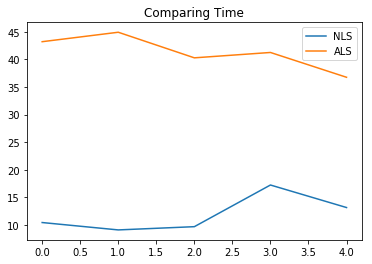

In [20]:
plt.plot(time_NLS, label ='NLS')
plt.plot(time_ALS, label='ALS')
plt.legend()
plt.title('Comparing Time')

Text(0.5, 1.0, 'Comparing Iterations')

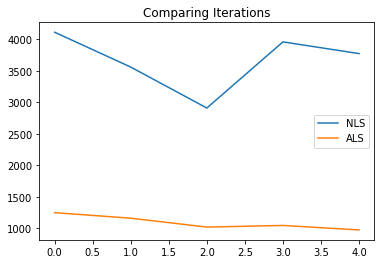

In [21]:
plt.plot(iter_NLS, label ='NLS')
plt.plot(iter_ALS, label='ALS')
plt.legend()
plt.title('Comparing Iterations')

In [17]:
n=3
s = 200
R = 100

X = np.random.rand(n,s,R)

delta = np.random.random_sample(X.shape)

start = time.time()
compute_JTJdel(X,delta)
end = time.time()

print("Time taken",end-start)

start = time.time()
fast_hessian_contract(X,delta)
end = time.time()
print("Time taken",end-start)


Time taken 0.053888559341430664
Time taken 23.375219106674194
